In [1]:
%matplotlib inline
import numpy as np
import os
import pathlib
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
#import keras
#import keras_applications, keras_preprocessing
import re
import cv2
import matplotlib.patches as patches
from sklearn import preprocessing
from matplotlib.image import imread
from tqdm import tqdm
import shutil
import seaborn as sns
from matplotlib.image import imsave

### check how .csv data look like

In [2]:
data_path = os.path.join('I:/Kaggle/Global Wheat Detection',  'train' + '.' + 'csv')
df_train = pd.DataFrame(pd.read_csv(data_path))
print(df_train.shape)
df_train.head()

(147793, 5)


image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

# Data preparation and preprocessing

### writing class to load and plot images
#### visualizing data and bounding boxes

In [24]:
class plot_bbox:
    def __init__(self, image_dir, annot_path, image_num, suffix_, df_sample):
        self.image_dir = image_dir
        self.annot_path = annot_path
        self.image_num = image_num
        self.suffix_ = suffix_
        self.df_sample = df_sample
        
    def load_images(self):
        dir_list = os.listdir(self.image_dir)
        pur_image_names = []
        [pur_image_names.append(img) for img in dir_list if img.endswith('.' + self.suffix_)]
        
        print('%d images are selected at random' % self.image_num)
        
        selected_image_names = np.random.choice(pur_image_names, size = self.image_num)
        
        # start loading images and locate them is 4D array
        images_array = []
        images_array = [imread(os.path.join(self.image_dir, name)) for name in selected_image_names]
        
        
        return images_array, selected_image_names
    
    def load_annotations(self):
        
        if self.df_sample:
            df_temp = pd.read_csv(self.annot_path)
            df_ = pd.DataFrame(columns=df_temp.columns)
            for i, names in enumerate(list(set(df_temp.source.values))):
                df_ = df_.append(df_temp[df_temp.source == names].sample(n = self.df_sample))
        else:
            df_ = pd.read_csv(self.annot_path)
        return df_
    
    def plot_(self):
        
        images_, image_names = self.load_images()
        
        df_annot = self.load_annotations()
        
        nr_ = self.image_num
        
        # creating plot
        subplot_row = int(np.ceil(nr_/4))
        subplot_col = 4
        f, axes = plt.subplots(subplot_row, subplot_col, figsize= (14, 3 * subplot_row))
        
        
        for i, ax in enumerate(axes.flat):
            try:
                ax.imshow(np.uint8(images_[i]), vmin = 0, vmax = 255, interpolation='nearest')
                ax.set_axis_off()
                ax.set_title(image_names[i])
                # add bbox per image
                # search for all bboxes per image name
                
                boxes = df_annot[df_annot.image_id == image_names[i][:-4]].bbox.values
                
                if 1:
                    for ind in range(boxes.shape[0]):
                        temp_box = re.findall('[0-9.]+', boxes[ind])
                        ax.add_patch(patches.Rectangle((float(temp_box[0]),float(temp_box[1])),
                                                       float(temp_box[2]),float(temp_box[3]),
                                                      linewidth = 1, edgecolor = 'r', 
                                                       facecolor = 'none'))
                
            except:
                ax.set_axis_off()
                print('number of axes are more than images')
            
        plt.show()
        
        
    def plot_given_input(self, input_images, input_image_names, nr_):
        
        images_ = input_images
        image_names = input_image_names
        
        df_annot = self.load_annotations()
        
        
        # creating plot
        subplot_row = int(np.ceil(nr_/4))
        subplot_col = 4
        f, axes = plt.subplots(subplot_row, subplot_col, figsize= (14, 3 * subplot_row))
        
        
        for i, ax in enumerate(axes.flat):
            try:
                ax.imshow(images_[i], vmin = 0, vmax = 255)
                ax.set_axis_off()
                ax.set_title(image_names[i])
                # add bbox per image
                # search for all bboxes per image name
                
                boxes = df_annot[df_annot.image_id == image_names[i][:-4]].bbox.values
                
                if 1:
                    for ind in range(boxes.shape[0]):
                        temp_box = re.findall('[0-9.]+', boxes[ind])
                        ax.add_patch(patches.Rectangle((float(temp_box[0]),float(temp_box[1])),
                                                       float(temp_box[2]),float(temp_box[3]),
                                                      linewidth = 1, edgecolor = 'r', 
                                                       facecolor = 'none'))
                
            except:
                ax.set_axis_off()
                print('number of axes are more than images')
            
        plt.show()
        
    def create_yolo_style1(self):
        image_dir_parent = str(pathlib.Path(self.image_dir).parent)
        print('creating new folder with name style1')
        if not os.path.isdir(os.path.join(image_dir_parent, 'style1')):
            os.makedirs(os.path.join(image_dir_parent, 'style1'))
        else:
            print('the folder was already created')
        save_path = os.path.join(image_dir_parent, 'style1')
        
        dir_list = os.listdir(self.image_dir)
        pur_image_names = []
        [pur_image_names.append(img) for img in dir_list if img.endswith('.' + self.suffix_)]
        
        # now take csv file and clean and save it as txt file
        df_ =  self.load_annotations()
        # make df_ more conviniet for later
        # initialize with 0
        df_ = df_.assign(**{'x': 0, 'y': 0, 'width_': 0, 'height_': 0,
                           'x_norm': 0, 'y_norm': 0, 'width_norm': 0, 'height_norm': 0})
        bbox_ = []
        [bbox_.append(list(map(float,re.findall('\d+(?:\.\d+)?', box)))) for box in df_.bbox]
        df_[['x', 'y', 'width_', 'height_']] = pd.DataFrame(bbox_)
        # shifting x and y from top corner to the center of the box
        df_['x'] =df_['x'] + np.round(df_['width_']/2)
        df_['y'] =df_['y'] + np.round(df_['height_']/2)
        list_ = list((df_.x.values / df_.width.values, df_.y.values / df_.height.values, df_.width_.values / df_.width.values, df_.height_.values / df_.height.values))
        list_ = list(map(list, zip(*list_)))
        df_[['x_norm', 'y_norm', 'width_norm', 'height_norm']] = pd.DataFrame(list_)
        
        #import pdb;pdb.set_trace()
        
        # now for each unique image name I have to create 1 .txt file
        # then start with finding unique names
        df_all_names = df_.image_id
        unique_names = list(set(df_all_names))
        print('it is creating text file, it could take a moment ...')
        [df_[df_.image_id == name].drop(['image_id', 'source', 'bbox', 'x', 'y', 'width_', 'height_'], axis = 1).assign(labels = 0).reindex(columns = ['labels', 'x_norm', 'y_norm', 'width_norm', 'height_norm']).to_csv(os.path.join(save_path, name + '.txt'), header=False, sep= ' ', index=False) for name in unique_names]
        print('start copying images, be patient ...')
        [shutil.copy(os.path.join(self.image_dir, name + '.' + self.suffix_), save_path) for name in unique_names]
        print('check files in ', save_path)
        
        
    def create_yolo_style2(self):
        image_dir_parent = str(pathlib.Path(self.image_dir).parent)
        print('creating new folder with name style2')
        if not os.path.isdir(os.path.join(image_dir_parent, 'style2')):
            os.makedirs(os.path.join(image_dir_parent, 'style2'))
        else:
            print('the folder was already created')
        save_path = os.path.join(image_dir_parent, 'style2')
        
        dir_list = os.listdir(self.image_dir)
        pur_image_names = []
        [pur_image_names.append(img) for img in dir_list if img.endswith('.' + self.suffix_)]
        
        # now take csv file and clean and save it as txt file
        df_ =  self.load_annotations()
        # make df_ more conviniet for later
        # initialize with 0
        df_ = df_.assign(**{'x': 0, 'y': 0, 'width_': 0, 'height_': 0,
                           'x_norm': 0, 'y_norm': 0, 'width_norm': 0, 'height_norm': 0})
        bbox_ = []
        [bbox_.append(list(map(float,re.findall('\d+(?:\.\d+)?', box)))) for box in df_.bbox]
        df_[['x', 'y', 'width_', 'height_']] = pd.DataFrame(bbox_)
        # shifting x and y from top corner to the center of the box
        df_['x'] =df_['x'] + np.round(df_['width_']/2)
        df_['y'] =df_['y'] + np.round(df_['height_']/2)
        list_ = list((df_.x.values / df_.width.values, df_.y.values / df_.height.values, df_.width_.values / df_.width.values, df_.height_.values / df_.height.values))
        list_ = list(map(list, zip(*list_)))
        df_[['x_norm', 'y_norm', 'width_norm', 'height_norm']] = pd.DataFrame(list_)
        
        
        
        # now for each unique image name I have to create 1 .txt file
        # then start with finding unique names
        df_all_names = df_.image_id
        unique_names = list(set(df_all_names))
        print('it is creating text file, it could take a moment ...')
        [df_[df_.image_id == name].drop(['image_id', 'source', 'bbox', 'x', 'y', 'width_', 'height_'], axis = 1).assign(labels = 0).reindex(columns = ['labels', 'x_norm', 'y_norm', 'width_norm', 'height_norm']).to_csv(os.path.join(save_path, name + '.txt'), header=False, sep= ' ', index=False) for name in unique_names]
        print('start copying images, be patient ...')
        [shutil.copy(os.path.join(self.image_dir, name + '.' + self.suffix_), save_path) for name in unique_names]
        
        #remained images
        print('creating txt files and copying images for remained images ...')
        remained_images = [image[:-4] for image in pur_image_names if image[:-4] not in unique_names]
        print('size of images without bbox: ', len(remained_images))
        print('size of images with bbox: ', len(unique_names))
        print('data is heavily imbalanced !!!')
        [shutil.copy(os.path.join(self.image_dir, name + '.' + self.suffix_), save_path) for name in remained_images]
        class__ = 1
        [np.savetxt(os.path.join(save_path, name + '.txt'), np.append(class__, np.zeros((1,4))), newline= ' ') for name in remained_images]
        print('check files in ', save_path)
        

### first visualization

16 images are selected at random


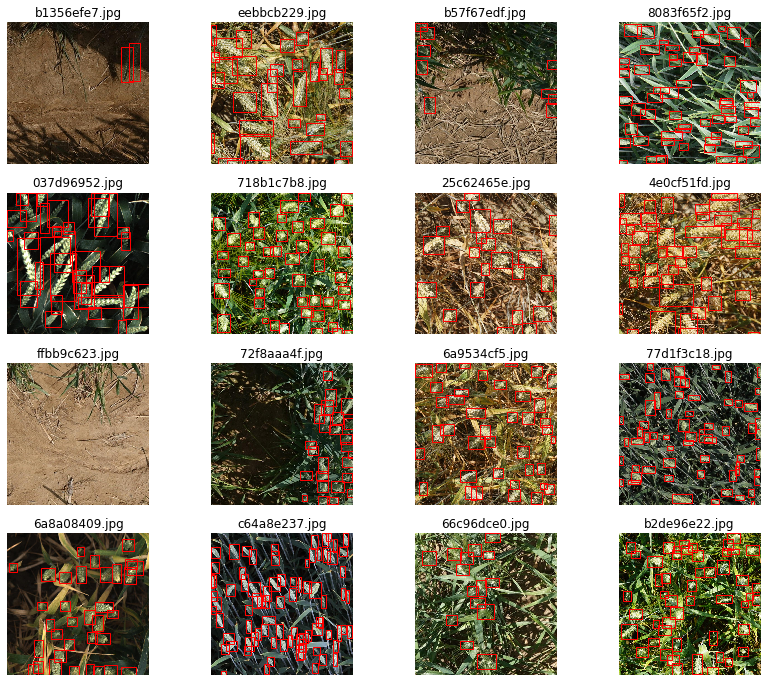

In [12]:

P = plot_bbox(image_dir='I:/Kaggle/Global Wheat Detection/train',
             image_num=16,
             annot_path='I:/Kaggle/Global Wheat Detection/train.csv',
             suffix_='jpg',
             df_sample=0)
P.plot_()

## Normalization step

In [14]:
# first read all data from image folder
P = plot_bbox(image_dir='I:/Kaggle/Global Wheat Detection/train',
             image_num=460,
             annot_path='I:/Kaggle/Global Wheat Detection/train.csv',
             suffix_='jpg',
             df_sample=0)
all_images, all_names = P.load_images()
len(all_images)
all_images_array = np.array(all_images)
print(all_images_array.shape)

460 images are selected at random
(460, 1024, 1024, 3)


In [10]:
def per_channel_norm(input_data, standard_,  rgb, hist_equal, ada_hist_equal):
    
    n, x, y, ch = input_data.shape
    
    # initialize
    input_data_norm = np.zeros_like(input_data)
    
    # first split channels
    r_channel = np.int32(input_data[:,:,:,0].reshape(-1,x*y))
    g_channel = np.int32(input_data[:,:,:,1].reshape(-1,x*y))
    b_channel = np.int32(input_data[:,:,:,2].reshape(-1,x*y))
    
    if standard_:
    
        r_channel = preprocessing.StandardScaler().fit_transform(r_channel)
        g_channel = preprocessing.StandardScaler().fit_transform(g_channel)
        b_channel = preprocessing.StandardScaler().fit_transform(b_channel)
        
        
        r_channel = preprocessing.MinMaxScaler().fit_transform(r_channel) * 255
        g_channel = preprocessing.MinMaxScaler().fit_transform(g_channel) * 255
        b_channel = preprocessing.MinMaxScaler().fit_transform(b_channel) * 255
        
    if rgb:
        imageMagnitude = np.sqrt(r_channel**2 + g_channel**2 + b_channel**2)
        r_channel = (r_channel / imageMagnitude) * 255
        g_channel = (g_channel / imageMagnitude) * 255
        b_channel = (b_channel / imageMagnitude) * 255
    
    input_data_norm[:,:,:,0] = np.uint8(r_channel.reshape(-1,x,y))
    input_data_norm[:,:,:,1] = np.uint8(g_channel.reshape(-1,x,y))
    input_data_norm[:,:,:,2] = np.uint8(b_channel.reshape(-1,x,y))
    
    if hist_equal:
        from cv2 import equalizeHist
        for i in range(input_data_norm.shape[0]):
            for ii in range(3):
                input_data_norm[i,:,:,ii] = equalizeHist(input_data_norm[i,:,:,ii])
        
    if ada_hist_equal:
        from cv2 import createCLAHE
        clahe = createCLAHE(clipLimit=1.6, tileGridSize=(16,16))
        for i in range(input_data_norm.shape[0]):
            for ii in range(3):
                input_data_norm[i,:,:,ii] = clahe.apply(input_data_norm[i,:,:,ii])
    
    
    return input_data_norm
    

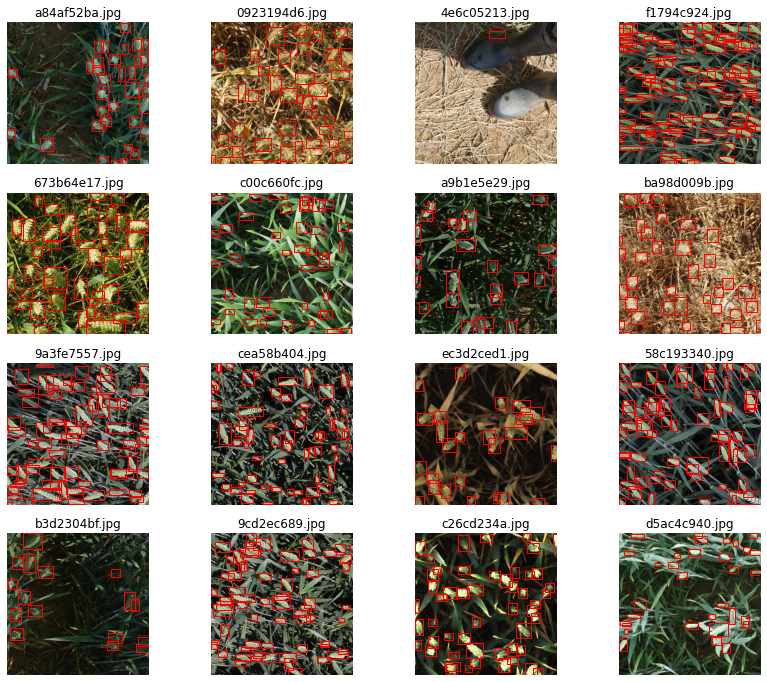

In [16]:
norm_images_ = per_channel_norm(all_images_array, False,  False, False, False)
P.plot_given_input(input_images=norm_images_[0:16], input_image_names=all_names[0:16], nr_=16)

### trying different normalization

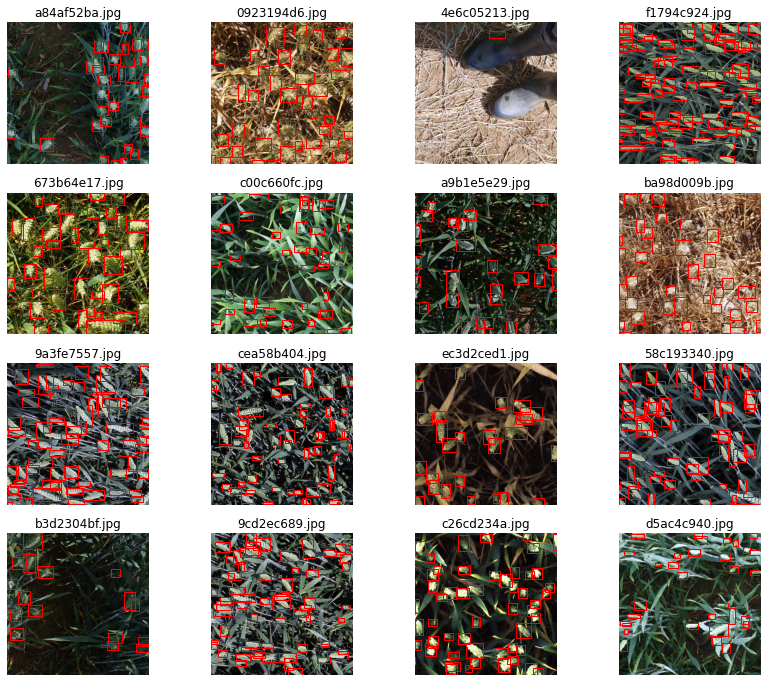

In [17]:
# normalizing data then scaling to between 0-1
norm_images = per_channel_norm(all_images_array, True,  False, False, False)
P.plot_given_input(input_images=norm_images[0:16], input_image_names=all_names[0:16], nr_=16)

c:\users\admin\anaconda3\envs\tf2.0.0\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
c:\users\admin\anaconda3\envs\tf2.0.0\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
c:\users\admin\anaconda3\envs\tf2.0.0\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


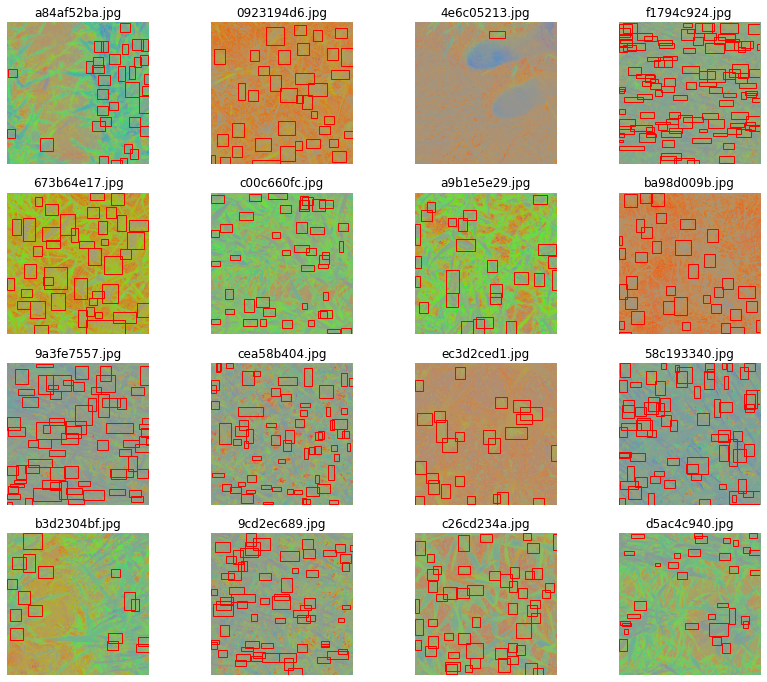

In [18]:
norm_images_rgb = per_channel_norm(all_images_array, False,  True, False, False)
P.plot_given_input(input_images=norm_images_rgb[0:16], input_image_names=all_names[0:16], nr_=16)

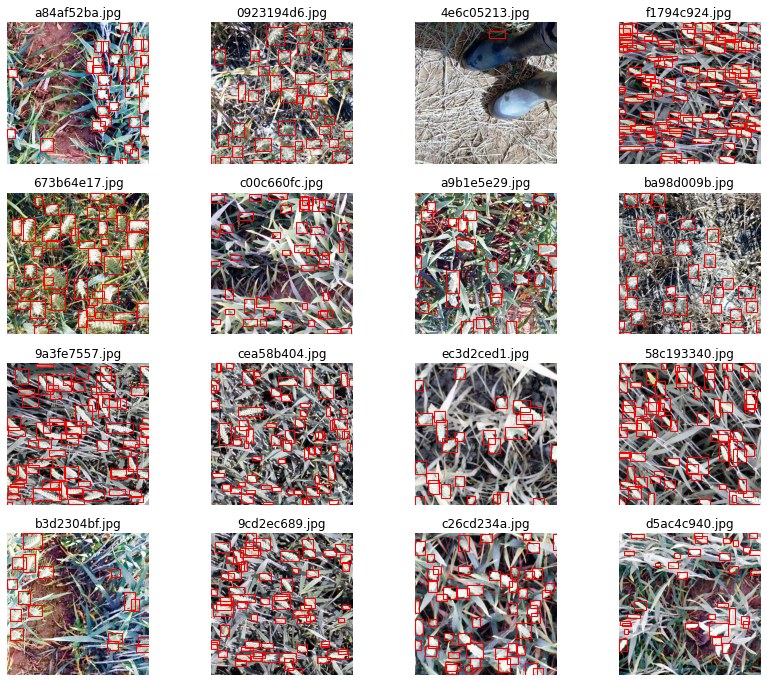

In [19]:
norm_images_rgb = per_channel_norm(all_images_array, False,  False, True, False)
P.plot_given_input(input_images=norm_images_rgb[0:16], input_image_names=all_names[0:16], nr_=16)

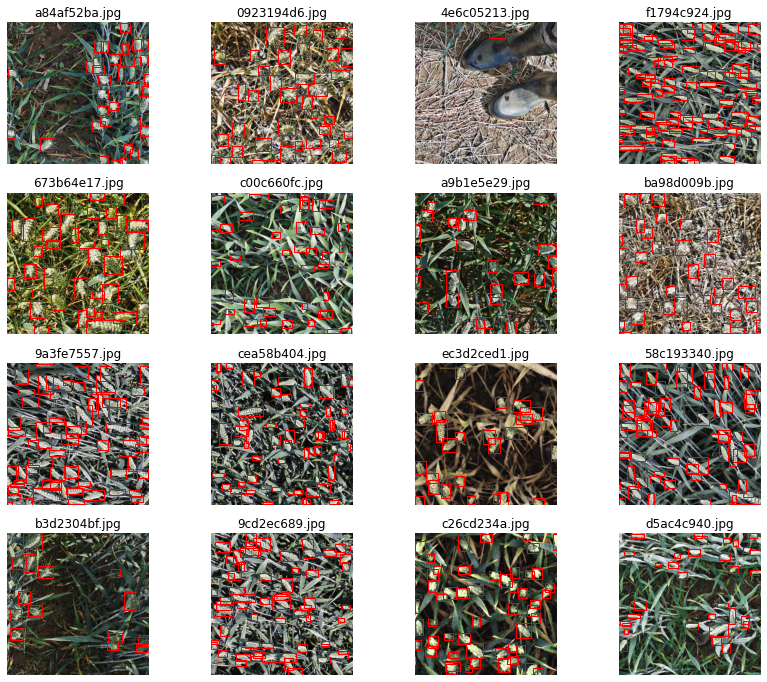

In [20]:
norm_images_rgb = per_channel_norm(all_images_array, False,  False, False, True)
P.plot_given_input(input_images=norm_images_rgb[0:16], input_image_names=all_names[0:16], nr_=16)

## Preparing Yolo annotation

From Kaggle page:  
What am I predicting?   
You are attempting to predict bounding boxes around each wheat head in images that have them. If there are no wheat heads, you must predict no bounding boxes.


txt-file for each .jpg-image-file - in the same directory and with the same name, but with .txt-extension, and put to file:    object number and object coordinates on this image, for each object in new line: <object-class> <x> <y> <width> <height>   

Where:   

object-class - integer number of object from 0 to (classes-1)   
x y width height - float values relative to width and height of image, it can be equal from (0.0 to 1.0]   
for example: x = absolute_x / image_width or height = absolute_height / image_height   
atention: x y - are center of rectangle (are not top-left corner)   
For example for img1.jpg you will be created img1.txt containing:   

1 0.716797 0.395833 0.216406 0.147222   
0 0.687109 0.379167 0.255469 0.158333   
1 0.420312 0.395833 0.140625 0.166667   

In [25]:
# Style 1
#   - when we have only 1 class and images without objects can be 
#     detected by thresholding detection probability

P = plot_bbox(image_dir='I:/Kaggle/Global Wheat Detection/train',
             image_num=16,
             annot_path='I:/Kaggle/Global Wheat Detection/train.csv',
             suffix_='jpg',
             df_sample=0)
P.create_yolo_style1()

creating new folder with name style1
the folder was already created
it is creating text file, it could take a moment ...
start copying images, be patient ...
check files in  I:\Kaggle\Global Wheat Detection\style1


In [317]:
# Style 2
#   - when we have two classes (with object and without object)
#        - The problem is for two classes detection we have strongly imbalanced dataset
#            - we can use data augmentation


P = plot_bbox(image_dir='C:/Users/Nima/Documents/Kaggle/Global Wheat Detection/global-wheat-detection/train',
             image_num=16,
             annot_path='C:/Users/Nima/Documents/Kaggle/Global Wheat Detection/global-wheat-detection/train.csv',
             suffix_='jpg',
             df_sample=0)
P.create_yolo_style2()

creating new folder with name style2
the folder was already created
it is creating text file, it could take a moment ...
start copying images, be patient ...
creating txt files and copying images for remained images ...
size of images without bbox:  49
size of images with bbox:  3373
data is heavily imbalanced !!!
check files in  I:\Kaggle\Global Wheat Detection\style2


0           usask_1
1           usask_1
2           usask_1
3           usask_1
4           usask_1
            ...    
147788    arvalis_2
147789    arvalis_2
147790    arvalis_2
147791    arvalis_2
147792    arvalis_2
Name: source, Length: 147793, dtype: object


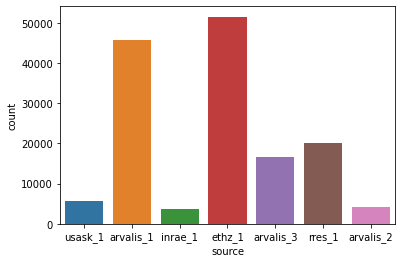

In [3]:
# considering each source as a class label
sns.countplot(x='source', data = df_train);
print(df_train.source)

In [4]:
df_train.groupby('source').count()

image_id  width  height   bbox
source                                   
arvalis_1     45716  45716   45716  45716
arvalis_2      4179   4179    4179   4179
arvalis_3     16665  16665   16665  16665
ethz_1        51489  51489   51489  51489
inrae_1        3701   3701    3701   3701
rres_1        20236  20236   20236  20236
usask_1        5807   5807    5807   5807

In [5]:
df2 = pd.DataFrame(columns=df_train.columns)
for i, names in enumerate(list(set(df_train.source.values))):
    df2 = df2.append(df_train[df_train.source == names].sample(n = 2))

In [6]:
df2

image_id width height                          bbox     source
47795   ac8eb0616  1024   1024              [972, 0, 48, 75]  arvalis_1
51271   fb2b30bc9  1024   1024              [0, 169, 60, 80]  arvalis_1
964     43e3ccd92  1024   1024    [323.0, 420.0, 75.0, 95.0]    usask_1
409     3e1e66c76  1024   1024  [768.0, 231.0, 189.0, 168.0]    usask_1
129799  a965d4117  1024   1024      [0.0, 468.0, 48.0, 59.0]     rres_1
137129  161f20a53  1024   1024  [558.0, 198.0, 109.0, 128.0]     rres_1
53094   26c2b1c78  1024   1024   [272.0, 424.0, 88.0, 114.0]    inrae_1
53915   c6d94be4c  1024   1024      [724.0, 0.0, 77.0, 35.0]    inrae_1
144170  e1f6c91bb  1024   1024   [878.0, 555.0, 69.0, 113.0]  arvalis_2
147269  5041b4b98  1024   1024  [570.0, 872.0, 164.0, 141.0]  arvalis_2
87053   7e69fb4da  1024   1024   [674.0, 292.0, 57.0, 109.0]     ethz_1
79287   0dbfcf802  1024   1024      [1.0, 812.0, 50.0, 48.0]     ethz_1
109338  57a6b42c8  1024   1024    [727.0, 855.0, 64.0, 84.0]  arvalis_3
114949  db3eb3f0c  1024   1024    [942.0, 652.0, 82.0, 54.0]  arvalis_3

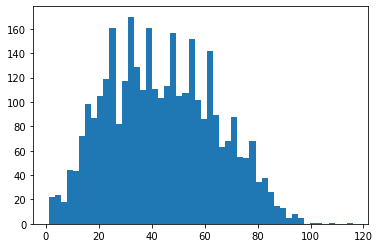

In [7]:
# number of bbox per image
plt.hist(df_train.groupby(['image_id']).count().values[:,0],50);

Text(0.5, 1.0, 'imbalanced data set')

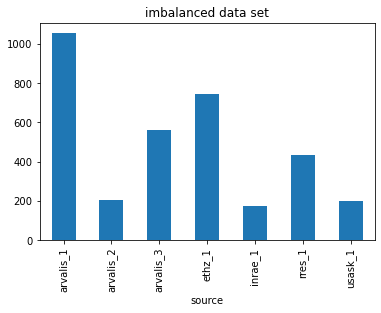

In [8]:
#number of images per source group
df2 = df_train.groupby(['image_id', 'source']).count()
data= df2.groupby(level = 'source').size().plot.bar()
plt.title('imbalanced data set')

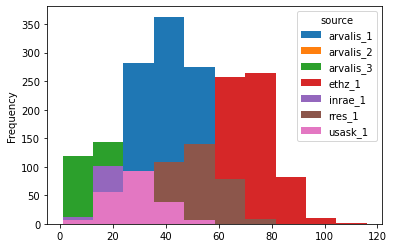

In [9]:
# distribution of patches per group
df_train.groupby(['image_id', 'source']).size().unstack(level=1).plot.hist()

In [8]:
#df2  = df_train[0:10]
df2['bbox_int'] = df2['bbox'].map(lambda x: re.findall('\d+(?:\.\d+)?',x))
df2

C:\Users\Nima\Anaconda3\envs\tf18\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


image_id  width  height                          bbox   source  \
0  b6ab77fd7   1024    1024    [834.0, 222.0, 56.0, 36.0]  usask_1   
1  b6ab77fd7   1024    1024   [226.0, 548.0, 130.0, 58.0]  usask_1   
2  b6ab77fd7   1024    1024   [377.0, 504.0, 74.0, 160.0]  usask_1   
3  b6ab77fd7   1024    1024   [834.0, 95.0, 109.0, 107.0]  usask_1   
4  b6ab77fd7   1024    1024   [26.0, 144.0, 124.0, 117.0]  usask_1   
5  b6ab77fd7   1024    1024  [569.0, 382.0, 119.0, 111.0]  usask_1   
6  b6ab77fd7   1024    1024     [52.0, 602.0, 82.0, 45.0]  usask_1   
7  b6ab77fd7   1024    1024   [627.0, 302.0, 122.0, 75.0]  usask_1   
8  b6ab77fd7   1024    1024    [412.0, 367.0, 68.0, 82.0]  usask_1   
9  b6ab77fd7   1024    1024   [953.0, 220.0, 56.0, 103.0]  usask_1   

                       bbox_int  
0    [834.0, 222.0, 56.0, 36.0]  
1   [226.0, 548.0, 130.0, 58.0]  
2   [377.0, 504.0, 74.0, 160.0]  
3   [834.0, 95.0, 109.0, 107.0]  
4   [26.0, 144.0, 124.0, 117.0]  
5  [569.0, 382.0, 119.0, 111.0]  
6     [52.0, 602.0, 82.0, 45.0]  
7   [627.0, 302.0, 122.0, 75.0]  
8    [412.0, 367.0, 68.0, 82.0]  
9   [953.0, 220.0, 56.0, 103.0]

Here I take images from folder and after normalizing them saving in another folder

In [32]:
image_dir='I:/Kaggle/Global Wheat Detection/train'

# create directory for saving normalized data
save_dir = os.path.join(os.path.dirname(image_dir), os.path.basename(image_dir) + '_normalized')
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
    print('creating directory')
else:
    print('directory is already exist')

creating directory


In [36]:
[imsave(os.path.join(save_dir,name),np.squeeze(per_channel_norm(np.expand_dims(image, axis = 0), False,  False, False, True))) 
 for name, image in all_images]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [26]:
all_images = [(image,imread(os.path.join(image_dir,image))) for 
        image in os.listdir(image_dir) if image.endswith('.jpg')]

In [35]:
[np.expand_dims(image, axis = 0).shape for name, image in all_images]

[(1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 1024, 3),
 (1, 1024, 10

### Results of prediction on test images - YOLOV3

In [3]:
import json

with open('I:/Kaggle/Global Wheat Detection/result.json') as json_file:
    data = json.load(json_file)

In [4]:
result_df = pd.json_normalize(data)
result_df

frame_id                filename  \
0         1  data/obj/cb8d261a3.jpg   
1         2  data/obj/51f1be19e.jpg   
2         3  data/obj/51b3e36ab.jpg   
3         4  data/obj/348a992bb.jpg   
4         5  data/obj/aac893a91.jpg   
5         6  data/obj/2fd875eaa.jpg   
6         7  data/obj/53f253011.jpg   
7         8  data/obj/f5a1f0358.jpg   
8         9  data/obj/cc3532ff6.jpg   
9        10  data/obj/796707dd7.jpg   

                                             objects  
0  [{'class_id': 0, 'name': 'wheat', 'relative_co...  
1  [{'class_id': 0, 'name': 'wheat', 'relative_co...  
2  [{'class_id': 0, 'name': 'wheat', 'relative_co...  
3  [{'class_id': 0, 'name': 'wheat', 'relative_co...  
4  [{'class_id': 0, 'name': 'wheat', 'relative_co...  
5  [{'class_id': 0, 'name': 'wheat', 'relative_co...  
6  [{'class_id': 0, 'name': 'wheat', 'relative_co...  
7  [{'class_id': 0, 'name': 'wheat', 'relative_co...  
8  [{'class_id': 0, 'name': 'wheat', 'relative_co...  
9  [{'class_id': 0, 'name': 'wheat', 'relative_co...

In [5]:
# correct file path to image name
result_df['filename'] = result_df.filename.apply(lambda x: os.path.split(x)[-1][:-4])
result_df

frame_id   filename                                            objects
0         1  cb8d261a3  [{'class_id': 0, 'name': 'wheat', 'relative_co...
1         2  51f1be19e  [{'class_id': 0, 'name': 'wheat', 'relative_co...
2         3  51b3e36ab  [{'class_id': 0, 'name': 'wheat', 'relative_co...
3         4  348a992bb  [{'class_id': 0, 'name': 'wheat', 'relative_co...
4         5  aac893a91  [{'class_id': 0, 'name': 'wheat', 'relative_co...
5         6  2fd875eaa  [{'class_id': 0, 'name': 'wheat', 'relative_co...
6         7  53f253011  [{'class_id': 0, 'name': 'wheat', 'relative_co...
7         8  f5a1f0358  [{'class_id': 0, 'name': 'wheat', 'relative_co...
8         9  cc3532ff6  [{'class_id': 0, 'name': 'wheat', 'relative_co...
9        10  796707dd7  [{'class_id': 0, 'name': 'wheat', 'relative_co...

In [6]:
# unstack bboxes of each image
result_df = result_df.explode('objects').reset_index()
result_df

index  frame_id   filename  \
0        0         1  cb8d261a3   
1        0         1  cb8d261a3   
2        0         1  cb8d261a3   
3        0         1  cb8d261a3   
4        0         1  cb8d261a3   
..     ...       ...        ...   
268      9        10  796707dd7   
269      9        10  796707dd7   
270      9        10  796707dd7   
271      9        10  796707dd7   
272      9        10  796707dd7   

                                               objects  
0    {'class_id': 0, 'name': 'wheat', 'relative_coo...  
1    {'class_id': 0, 'name': 'wheat', 'relative_coo...  
2    {'class_id': 0, 'name': 'wheat', 'relative_coo...  
3    {'class_id': 0, 'name': 'wheat', 'relative_coo...  
4    {'class_id': 0, 'name': 'wheat', 'relative_coo...  
..                                                 ...  
268  {'class_id': 0, 'name': 'wheat', 'relative_coo...  
269  {'class_id': 0, 'name': 'wheat', 'relative_coo...  
270  {'class_id': 0, 'name': 'wheat', 'relative_coo...  
271  {'class_id': 0, 'name': 'wheat', 'relative_coo...  
272  {'class_id': 0, 'name': 'wheat', 'relative_coo...  

[273 rows x 4 columns]

In [7]:
# clean up objects and make [confidence x y width height]
result_df['bbox'] = result_df['objects'].apply(lambda x: [x['confidence'], x['relative_coordinates']['center_x'], 
                                                      x['relative_coordinates']['center_y'], 
                                                      x['relative_coordinates']['width'], 
                                                      x['relative_coordinates']['height']])
result_df

index  frame_id   filename  \
0        0         1  cb8d261a3   
1        0         1  cb8d261a3   
2        0         1  cb8d261a3   
3        0         1  cb8d261a3   
4        0         1  cb8d261a3   
..     ...       ...        ...   
268      9        10  796707dd7   
269      9        10  796707dd7   
270      9        10  796707dd7   
271      9        10  796707dd7   
272      9        10  796707dd7   

                                               objects  \
0    {'class_id': 0, 'name': 'wheat', 'relative_coo...   
1    {'class_id': 0, 'name': 'wheat', 'relative_coo...   
2    {'class_id': 0, 'name': 'wheat', 'relative_coo...   
3    {'class_id': 0, 'name': 'wheat', 'relative_coo...   
4    {'class_id': 0, 'name': 'wheat', 'relative_coo...   
..                                                 ...   
268  {'class_id': 0, 'name': 'wheat', 'relative_coo...   
269  {'class_id': 0, 'name': 'wheat', 'relative_coo...   
270  {'class_id': 0, 'name': 'wheat', 'relative_coo...   
271  {'class_id': 0, 'name': 'wheat', 'relative_coo...   
272  {'class_id': 0, 'name': 'wheat', 'relative_coo...   

                                                  bbox  
0    [0.982258, 0.547507, 0.322796, 0.083865, 0.139...  
1    [0.957724, 0.061629, 0.912692, 0.074083, 0.14661]  
2    [0.950657, 0.710555, 0.197127, 0.069482, 0.182...  
3    [0.945287, 0.622942, 0.300807, 0.067778, 0.127...  
4    [0.942375, 0.351851, 0.246784, 0.10077, 0.222185]  
..                                                 ...  
268  [0.366041, 0.298047, 0.516035, 0.080971, 0.140...  
269  [0.310602, 0.290052, 0.443199, 0.108931, 0.248...  
270   [0.290127, 0.088413, 0.60156, 0.074372, 0.07271]  
271  [0.244373, 0.159912, 0.822925, 0.084641, 0.105...  
272  [0.224922, 0.705243, 0.629631, 0.089695, 0.138...  

[273 rows x 5 columns]

In [8]:
# correct x_center y _center to x_top y_top and set them to real dimension 1024
result_df['bbox'] = result_df['bbox'].apply(lambda x: [x[0], (x[1]-(x[3]/2)) * 1024, 
                                                       (x[2] - (x[4]/2)) * 1024, x[3] *1024 , x[4] * 1024])
result_df

index  frame_id   filename  \
0        0         1  cb8d261a3   
1        0         1  cb8d261a3   
2        0         1  cb8d261a3   
3        0         1  cb8d261a3   
4        0         1  cb8d261a3   
..     ...       ...        ...   
268      9        10  796707dd7   
269      9        10  796707dd7   
270      9        10  796707dd7   
271      9        10  796707dd7   
272      9        10  796707dd7   

                                               objects  \
0    {'class_id': 0, 'name': 'wheat', 'relative_coo...   
1    {'class_id': 0, 'name': 'wheat', 'relative_coo...   
2    {'class_id': 0, 'name': 'wheat', 'relative_coo...   
3    {'class_id': 0, 'name': 'wheat', 'relative_coo...   
4    {'class_id': 0, 'name': 'wheat', 'relative_coo...   
..                                                 ...   
268  {'class_id': 0, 'name': 'wheat', 'relative_coo...   
269  {'class_id': 0, 'name': 'wheat', 'relative_coo...   
270  {'class_id': 0, 'name': 'wheat', 'relative_coo...   
271  {'class_id': 0, 'name': 'wheat', 'relative_coo...   
272  {'class_id': 0, 'name': 'wheat', 'relative_coo...   

                                                  bbox  
0    [0.982258, 517.7082879999999, 259.202560000000...  
1    [0.957724, 25.177600000000005, 859.532288, 75....  
2    [0.950657, 692.033536, 108.163072, 71.149568, ...  
3    [0.945287, 603.190272, 242.619392, 69.404672, ...  
4    [0.942375, 308.701184, 138.94809600000002, 103...  
..                                                 ...  
268  [0.366041, 263.742976, 456.589824, 82.914304, ...  
269  [0.310602, 241.24057599999998, 326.601728, 111...  
270  [0.290127, 52.45644800000001, 578.76992, 76.15...  
271  [0.244373, 120.413696, 788.5941760000001, 86.6...  
272  [0.224922, 676.2449919999999, 573.829120000000...  

[273 rows x 5 columns]

In [9]:
# this makes it easier to save csv file

result_df[['confidence', 'x_top', 'y_top', 'width', 'height']] = pd.DataFrame(result_df['bbox'].tolist())
result_df

index  frame_id   filename  \
0        0         1  cb8d261a3   
1        0         1  cb8d261a3   
2        0         1  cb8d261a3   
3        0         1  cb8d261a3   
4        0         1  cb8d261a3   
..     ...       ...        ...   
268      9        10  796707dd7   
269      9        10  796707dd7   
270      9        10  796707dd7   
271      9        10  796707dd7   
272      9        10  796707dd7   

                                               objects  \
0    {'class_id': 0, 'name': 'wheat', 'relative_coo...   
1    {'class_id': 0, 'name': 'wheat', 'relative_coo...   
2    {'class_id': 0, 'name': 'wheat', 'relative_coo...   
3    {'class_id': 0, 'name': 'wheat', 'relative_coo...   
4    {'class_id': 0, 'name': 'wheat', 'relative_coo...   
..                                                 ...   
268  {'class_id': 0, 'name': 'wheat', 'relative_coo...   
269  {'class_id': 0, 'name': 'wheat', 'relative_coo...   
270  {'class_id': 0, 'name': 'wheat', 'relative_coo...   
271  {'class_id': 0, 'name': 'wheat', 'relative_coo...   
272  {'class_id': 0, 'name': 'wheat', 'relative_coo...   

                                                  bbox  confidence  \
0    [0.982258, 517.7082879999999, 259.202560000000...    0.982258   
1    [0.957724, 25.177600000000005, 859.532288, 75....    0.957724   
2    [0.950657, 692.033536, 108.163072, 71.149568, ...    0.950657   
3    [0.945287, 603.190272, 242.619392, 69.404672, ...    0.945287   
4    [0.942375, 308.701184, 138.94809600000002, 103...    0.942375   
..                                                 ...         ...   
268  [0.366041, 263.742976, 456.589824, 82.914304, ...    0.366041   
269  [0.310602, 241.24057599999998, 326.601728, 111...    0.310602   
270  [0.290127, 52.45644800000001, 578.76992, 76.15...    0.290127   
271  [0.244373, 120.413696, 788.5941760000001, 86.6...    0.244373   
272  [0.224922, 676.2449919999999, 573.829120000000...    0.224922   

          x_top       y_top       width      height  
0    517.708288  259.202560   85.877760  142.681088  
1     25.177600  859.532288   75.860992  150.128640  
2    692.033536  108.163072   71.149568  187.389952  
3    603.190272  242.619392   69.404672  130.813952  
4    308.701184  138.948096  103.188480  227.517440  
..          ...         ...         ...         ...  
268  263.742976  456.589824   82.914304  143.660032  
269  241.240576  326.601728  111.545344  254.468096  
270   52.456448  578.769920   76.156928   74.455040  
271  120.413696  788.594176   86.672384  108.162048  
272  676.244992  573.829120   91.847680  141.826048  

[273 rows x 10 columns]

In [10]:
# saving result only name and bbox
result_df.drop(columns=['index', 'frame_id', 'objects', 'bbox']).to_csv('I:/Kaggle/Global Wheat Detection/results.csv', index=False)

In [11]:
# prepare differently

result_df = pd.json_normalize(data)
# correct file path to image name
result_df['filename'] = result_df.filename.apply(lambda x: os.path.split(x)[-1][:-4])
result_df

frame_id   filename                                            objects
0         1  cb8d261a3  [{'class_id': 0, 'name': 'wheat', 'relative_co...
1         2  51f1be19e  [{'class_id': 0, 'name': 'wheat', 'relative_co...
2         3  51b3e36ab  [{'class_id': 0, 'name': 'wheat', 'relative_co...
3         4  348a992bb  [{'class_id': 0, 'name': 'wheat', 'relative_co...
4         5  aac893a91  [{'class_id': 0, 'name': 'wheat', 'relative_co...
5         6  2fd875eaa  [{'class_id': 0, 'name': 'wheat', 'relative_co...
6         7  53f253011  [{'class_id': 0, 'name': 'wheat', 'relative_co...
7         8  f5a1f0358  [{'class_id': 0, 'name': 'wheat', 'relative_co...
8         9  cc3532ff6  [{'class_id': 0, 'name': 'wheat', 'relative_co...
9        10  796707dd7  [{'class_id': 0, 'name': 'wheat', 'relative_co...

In [12]:
result_df['bbox'] = result_df['objects'].apply(lambda test: np.hstack([[x['confidence'] , 
                                                      (x['relative_coordinates']['center_x'] - (x['relative_coordinates']['width']/2)) * 1024, 
                                                      (x['relative_coordinates']['center_y'] - (x['relative_coordinates']['height']/2)) * 1024, 
                                                      x['relative_coordinates']['width'] *1024, 
                                                      x['relative_coordinates']['height'] *1024] for x in test]))

In [143]:
result_df

frame_id   filename                                            objects  \
0         1  cb8d261a3  [{'class_id': 0, 'name': 'wheat', 'relative_co...   
1         2  51f1be19e  [{'class_id': 0, 'name': 'wheat', 'relative_co...   
2         3  51b3e36ab  [{'class_id': 0, 'name': 'wheat', 'relative_co...   
3         4  348a992bb  [{'class_id': 0, 'name': 'wheat', 'relative_co...   
4         5  aac893a91  [{'class_id': 0, 'name': 'wheat', 'relative_co...   
5         6  2fd875eaa  [{'class_id': 0, 'name': 'wheat', 'relative_co...   
6         7  53f253011  [{'class_id': 0, 'name': 'wheat', 'relative_co...   
7         8  f5a1f0358  [{'class_id': 0, 'name': 'wheat', 'relative_co...   
8         9  cc3532ff6  [{'class_id': 0, 'name': 'wheat', 'relative_co...   
9        10  796707dd7  [{'class_id': 0, 'name': 'wheat', 'relative_co...   

                                                bbox  
0  [0.982258, 517.7082879999999, 259.202560000000...  
1  [0.959623, 773.115904, 878.923776, 142.245888,...  
2  [0.983322, 7.099392000000002, 418.809344, 87.6...  
3  [0.98316, 735.5289600000001, 218.110976, 141.0...  
4  [0.923431, 616.13568, 913.928704, 74.889216, 1...  
5  [0.986349, 467.42886400000003, 349.77792, 125....  
6  [0.987495, 16.444928000000004, 28.876799999999...  
7  [0.986117, 131.73964800000002, 745.459712, 169...  
8  [0.960988, 100.47027200000001, 601.022464, 81....  
9  [0.959815, 706.35008, 819.571712, 118.841344, ...

In [13]:
submission = pd.DataFrame(columns=['image_id', 'PredictionStrings'])
submission['image_id'] = result_df['filename']
submission['PredictionStrings'] = result_df['bbox']
submission

image_id                                  PredictionStrings
0  cb8d261a3  [0.982258, 517.7082879999999, 259.202560000000...
1  51f1be19e  [0.959623, 773.115904, 878.923776, 142.245888,...
2  51b3e36ab  [0.983322, 7.099392000000002, 418.809344, 87.6...
3  348a992bb  [0.98316, 735.5289600000001, 218.110976, 141.0...
4  aac893a91  [0.923431, 616.13568, 913.928704, 74.889216, 1...
5  2fd875eaa  [0.986349, 467.42886400000003, 349.77792, 125....
6  53f253011  [0.987495, 16.444928000000004, 28.876799999999...
7  f5a1f0358  [0.986117, 131.73964800000002, 745.459712, 169...
8  cc3532ff6  [0.960988, 100.47027200000001, 601.022464, 81....
9  796707dd7  [0.959815, 706.35008, 819.571712, 118.841344, ...

In [14]:
[print(d.min(), d.max(), d.shape) for d in submission['PredictionStrings']]

-0.8939519999999987 998.647808 (130,)
-1.8964479999999995 919.2284159999999 (90,)
-3.0873599999999968 968.2544640000001 (140,)
-1.3199359999999984 992.2068479999999 (190,)
0.239062 970.376192 (120,)
-2.354688000000003 999.796224 (145,)
-1.5692799999999991 993.002496 (155,)
-0.7761920000000018 935.90784 (145,)
-4.493824000000004 992.754688 (130,)
-2.6557439999999986 936.095232 (120,)


[None, None, None, None, None, None, None, None, None, None]

In [15]:
submission['PredictionStrings'] = submission['PredictionStrings'].apply(lambda x: np.where(x>=0, x, 0))
[print(d.min(), d.max(), d.shape) for d in submission['PredictionStrings']]

0.0 998.647808 (130,)
0.0 919.2284159999999 (90,)
0.0 968.2544640000001 (140,)
0.0 992.2068479999999 (190,)
0.239062 970.376192 (120,)
0.0 999.796224 (145,)
0.0 993.002496 (155,)
0.0 935.90784 (145,)
0.0 992.754688 (130,)
0.0 936.095232 (120,)


[None, None, None, None, None, None, None, None, None, None]

In [16]:
submission

image_id                                  PredictionStrings
0  cb8d261a3  [0.982258, 517.7082879999999, 259.202560000000...
1  51f1be19e  [0.959623, 773.115904, 878.923776, 142.245888,...
2  51b3e36ab  [0.983322, 7.099392000000002, 418.809344, 87.6...
3  348a992bb  [0.98316, 735.5289600000001, 218.110976, 141.0...
4  aac893a91  [0.923431, 616.13568, 913.928704, 74.889216, 1...
5  2fd875eaa  [0.986349, 467.42886400000003, 349.77792, 125....
6  53f253011  [0.987495, 16.444928000000004, 28.876799999999...
7  f5a1f0358  [0.986117, 131.73964800000002, 745.459712, 169...
8  cc3532ff6  [0.960988, 100.47027200000001, 601.022464, 81....
9  796707dd7  [0.959815, 706.35008, 819.571712, 118.841344, ...

In [157]:
submission.to_csv('I:/Kaggle/Global Wheat Detection/result.csv', index=False, date_format=float)

In [25]:
test.to_csv('I:/Kaggle/Global Wheat Detection/test.csv', index=False, date_format=float)

In [23]:
test['PredictionStrings'] = test['PredictionStrings'].apply(lambda x: list(x))
test

image_id                                  PredictionStrings
0  cb8d261a3  [0.982258, 517.7082879999999, 259.202560000000...
1  51f1be19e  [0.959623, 773.115904, 878.923776, 142.245888,...
2  51b3e36ab  [0.983322, 7.099392000000002, 418.809344, 87.6...
3  348a992bb  [0.98316, 735.5289600000001, 218.110976, 141.0...
4  aac893a91  [0.923431, 616.13568, 913.928704, 74.889216, 1...
5  2fd875eaa  [0.986349, 467.42886400000003, 349.77792, 125....
6  53f253011  [0.987495, 16.444928000000004, 28.876799999999...
7  f5a1f0358  [0.986117, 131.73964800000002, 745.459712, 169...
8  cc3532ff6  [0.960988, 100.47027200000001, 601.022464, 81....
9  796707dd7  [0.959815, 706.35008, 819.571712, 118.841344, ...

In [24]:
test['PredictionStrings'][0]

[0.982258,
 517.7082879999999,
 259.20256000000006,
 85.87776,
 142.681088,
 0.957724,
 25.177600000000005,
 859.532288,
 75.860992,
 150.12864,
 0.950657,
 692.033536,
 108.163072,
 71.149568,
 187.389952,
 0.945287,
 603.190272,
 242.619392,
 69.404672,
 130.813952,
 0.942375,
 308.701184,
 138.94809600000002,
 103.18848,
 227.51744,
 0.928014,
 27.751424,
 560.534016,
 168.521728,
 102.157312,
 0.921421,
 840.6528000000001,
 145.624576,
 64.724992,
 131.72224,
 0.890244,
 903.2192,
 165.791744,
 95.461376,
 128.055296,
 0.848662,
 798.31552,
 206.531584,
 68.10624,
 120.666112,
 0.813196,
 753.92256,
 486.0032,
 118.510592,
 94.329856,
 0.811279,
 262.147072,
 765.5823359999999,
 119.607296,
 83.224576,
 0.79355,
 467.10886400000004,
 917.6401920000001,
 188.49792,
 102.782976,
 0.772875,
 0.0,
 796.970496,
 48.211968,
 79.05792,
 0.71877,
 652.232192,
 677.871104,
 86.852608,
 71.177216,
 0.688038,
 755.551744,
 704.031744,
 80.671744,
 107.45856,
 0.674905,
 438.250496,
 458.73408